<div style = "text-align: center; color: black; font-family: Times New Roman;">
  <strong><h1>S&P 500 LASSO REGRESSION<strong></h1>
</div>

<h3 style="font-family: 'Times New Roman'; color: black;">Library Imports</h3>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  We begin by importing the necessary Python libraries for this analysis. These include modules for data manipulation 
  (<code>pandas</code>, <code>numpy</code>), statistical modeling (<code>statsmodels</code>, <code>scikit-learn</code>), 
  and visualization (<code>matplotlib</code>). The libraries support tasks such as preprocessing and splitting datasets, 
  implementing Lasso regression, evaluating model performance, and generating insightful plots. To clarify potential confusion, note that alpha and lambda are synonymous terms. Lambda is more commonly used in statistical literature, while alpha appears more frequently in Python documentation.
</p>

In [102]:
# Importing essential libraries for Lasso regression, data preprocessing, and evaluation
import pandas as pd  # Data manipulation and analysis
import matplotlib.pyplot as plt  # Plotting and visualization
import numpy as np  # Numerical operations and array handling
from sklearn.model_selection import train_test_split  # Splitting data into training and testing sets
import statsmodels.api as sm  # Statistical modeling and inference (optional for comparison)
from sklearn import metrics  # Model evaluation utilities
from sklearn.linear_model import LassoCV  # Lasso regression with built-in cross-validation for tuning alpha
from sklearn.preprocessing import StandardScaler  # Feature scaling to standardize variables
from sklearn.metrics import mean_squared_error  # Calculate MSE and RMSE for model performance
import matplotlib.cm as cm  # Colormap support for visual styling
from sklearn.linear_model import Lasso  # Standard Lasso regression implementation

<h3 style="font-family: 'Times New Roman'; color: black;">Data Loading and Preparation</h3>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  The dataset is loaded from a merged CSV file (refer to the data cleaning folder) containing macroeconomic indicators 
  and stock market indices. We replace long names with simpler, Python-friendly labels.
</p>

In [103]:
# Load the merged dataset from a CSV file
data = pd.read_csv('merged_data.csv')

# Rename columns for clarity and consistency across the analysis
data.rename(columns={
    'CPALWE01USQ661N': 'CPI',
    'S&P 500 ^GSPC': 'S&P_500',
    'NASDAQ ^IXIC': 'NASDAQ',
    'Dow Jones ^DJI': 'Dow_Jones',
    'RealInterestRate': 'Real_IR',
    'UnemploymentRate': 'Unemployment_Rate',
    'FedFundsRate': 'Federal_Funds_Rate'
}, inplace = True)

# Display the first 10 rows to verify that the data was loaded and renamed correctly
data.head(10)

,Date,S&P_500,NASDAQ,Dow_Jones,CPI,Real_IR,Unemployment_Rate,GDP_Growth,M2_Supply,Federal_Funds_Rate
0,1992-01-01,408.779999,620.210022,3223.399902,58.870052,3.198542,7.3,4.9,3398.6,4.03
1,1992-04-01,414.950012,578.679993,3359.100098,59.387717,3.789860,7.4,4.4,3434.1,3.73
2,1992-07-01,424.209991,580.830017,3393.800049,59.862244,3.353099,7.7,4.0,3407.1,3.25
3,1992-10-01,418.679993,605.169983,3226.300049,60.279252,2.728044,7.3,4.2,3413.8,3.10
4,1993-01-01,438.779999,696.340027,3310.000000,60.696260,3.267908,7.3,0.7,3455.2,3.02
5,1993-04-01,440.190002,661.419983,3427.550049,61.185166,2.774517,7.1,2.3,3438.6,2.96
6,1993-07-01,448.130005,704.700012,3539.469971,61.415239,2.591799,6.9,1.9,3450.7,3.06
7,1993-10-01,467.829987,779.260010,3680.590088,61.832248,2.398843,6.8,5.6,3449.1,2.99
8,1994-01-01,481.609985,800.469971,3978.360107,62.119840,2.772685,6.6,3.9,3502.8,3.05
9,1994-04-01,450.910004,733.840027,3681.689941,62.551227,3.659183,6.4,5.5,3507.2,3.56


<h3 style="font-family: 'Times New Roman'; color: black;">Defining Variables for Lasso Regression</h3>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  We assigned key macroeconomic indicators such as CPI, real interest rate, unemployment rate, GDP growth, money supply (M2), 
  and the federal funds rate as the independent variables.
</p>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  The dependent variable is set as the S&P 500 index (which we are essentially trying to predict).
</p>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  These variables are then separated into feature matrix <code>x</code> and target vector <code>y</code> for use in the 
  Lasso regression model.
</p>

In [104]:
# Define the independent (predictor) and dependent (target) variables for the Lasso regression
independent_variables = ['CPI', 'Real_IR', 'Unemployment_Rate', 'GDP_Growth', 'M2_Supply', 'Federal_Funds_Rate']
dependent_variable = ['S&P_500']

# Extract the independent variables from the dataset
x = data[independent_variables]

# Extract the dependent variable (S&P 500 index values) from the dataset
y = data[dependent_variable]

<h3 style="font-family: 'Times New Roman'; color: black;">Lasso Regression Workflow</h3>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  To model the relationship between macroeconomic indicators and the S&P 500 index, we perform Lasso regression with the following steps:
</p>
<ol style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  <li><strong>Train-Test Split</strong>: The dataset is divided into training and testing sets using an 80/20 split without shuffling, preserving the temporal sequence of observations — which is important for time-series-like data.</li>
  <li><strong>Feature Scaling</strong>: Standardization is applied to the independent variables using <code>StandardScaler</code> to normalize the input data, which is essential for Lasso regression since it is sensitive to the scale of input features. It takes the normal scale of input features and transform it into standard normal form with a mean = 0 and standard deviation = 1.</li>
  <li><strong>Model Training</strong>: A Lasso regression model with 5-fold cross-validation is fit to the scaled training data to determine the optimal regularization strength (lambda). The <code>.ravel()</code> method is used on the target vector to suppress shape-related warnings.</li>
  <li><strong>Prediction and Evaluation</strong>: The trained model is used to predict the test set outcomes. Root Mean Squared Error (RMSE) and Mean Squared Error (MSE) are computed to evaluate model performance.</li>
  <li><strong>Results Summary</strong>: The optimal lambda value and the learned coefficients for each independent variable are displayed, highlighting the variables that most influence the prediction of the S&P 500 index.</li>
</ol>

In [105]:
# Split the data into training and testing sets (80/20 split),
# preserving the time-series structure by setting shuffle = False
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = False)

In [106]:
# Standardize the independent variables: transform to standard normal (mean = 0, std = 1)
# This step is needed for Lasso regression, which is sensitive to feature scale
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
x_train_scaled = scaler.fit_transform(x_train)

# Apply the same transformation to the test data
x_test_scaled = scaler.transform(x_test)

In [108]:
# Run Lasso regression with 5-fold cross-validation on the training set
lasso = LassoCV(cv = 5, random_state = 42)

# Fit the model on the standardized training data
# Used .ravel() to convert y to a 1D array and suppress shape-related warnings (Consulted generative AI)
lasso.fit(x_train_scaled, y_train.to_numpy().ravel())

# Retrieve the optimal regularization parameter (alpha) selected via cross-validation
optimal_lambda = lasso.alpha_

# Extract the fitted model coefficients
coefficient = lasso.coef_

In [109]:
# Generate predictions on the test set using the trained Lasso model
y_pred = lasso.predict(x_test_scaled)

# Calculate Root Mean Squared Error (RMSE) to evaluate prediction accuracy
rmse = (mean_squared_error(y_test, y_pred)) ** 0.5

# Calculate Mean Squared Error (MSE) for completeness
mse = rmse ** 2

In [110]:
# Extract individual coefficients for interpretation
cpi = coefficient[0]
real_ir = coefficient[1]
unemployment = coefficient[2]
gdp_growth = coefficient[3]
m2_supply = coefficient[4]
fed_funds = coefficient[5]

# Print model evaluation and selected coefficients in a formatted summary
print(f'----Test RMSE: {rmse:.2f}---Optimal Lambda: {optimal_lambda:.2f}---'
      f'CPI: {cpi:.2f}---Real Interest Rate: {real_ir:.2f}---Unemployment Rate: {unemployment:.2f}---'
      f'GDP Growth: {gdp_growth:.2f}---M2 Money Supply: {m2_supply:.2f}---Federal Funds Rate: {fed_funds:.2f}----')

----Test RMSE: 738.24---Optimal Lambda: 1.55---CPI: 196.59---Real Interest Rate: -0.00---Unemployment Rate: -197.29---GDP Growth: 46.16---M2 Money Supply: 309.16---Federal Funds Rate: 40.93----


<h3 style="font-family: 'Times New Roman'; color: black;">Interpretation of Lasso Regression Results</h3>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  The Lasso regression model yields a <strong>test RMSE of 738.24</strong>, indicating the average deviation between the predicted and actual S&P 500 values on the test set. 
  While the magnitude of the deviation is relatively high, it provides a baseline measure of model performance in this macroeconomic context.
</p>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  The model selected an <strong>optimal lambda (regularization strength) of 1.55</strong>, which penalizes less relevant features and helps prevent overfitting. Based on the learned coefficients:
</p>
<ul style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  <li><strong>CPI (196.59-)</strong> and <strong>M2 Supply (309.16)</strong> show the strongest positive influence on the S&P 500 index, suggesting that inflationary trends and money supply expansion are positively associated with stock market performance.</li>
  <li><strong>Unemployment Rate (-197.29)</strong> exhibits a strong negative impact, aligning with economic intuition that higher unemployment correlates with weaker market performance.</li>
</ul>

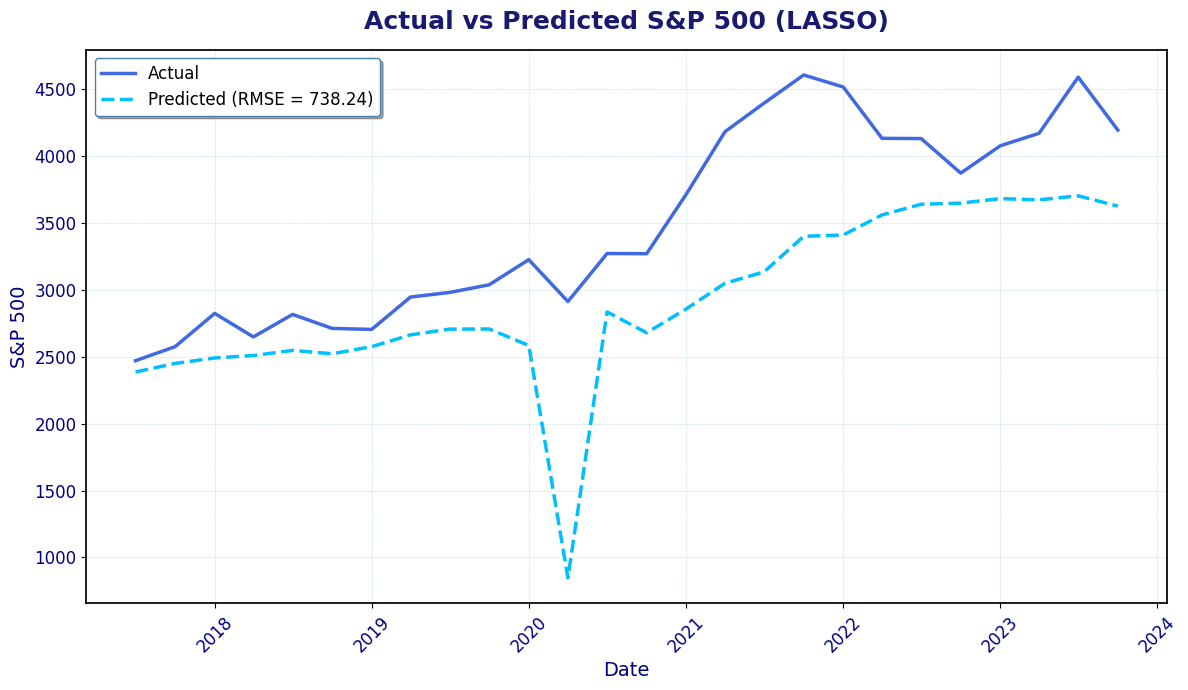

In [111]:
# Convert the 'Date' column to datetime format for accurate plotting on the x-axis
# (Plot aesthetics consulted generative AI)
data['Date'] = pd.to_datetime(data['Date'])

# Extract the corresponding test set dates based on x_test indices
dates = data['Date'].iloc[x_test.index]

# Create a plot comparing actual vs. predicted S&P 500 values using the Lasso model
plt.figure(figsize = (12, 7))  # Set figure size for readability

# Plot actual S&P 500 values
plt.plot(dates, y_test.values, 
         label = 'Actual', 
         color = 'royalblue', 
         linewidth = 2.5)

# Plot predicted values from the Lasso model
plt.plot(dates, y_pred, 
         label = 'Predicted (RMSE = 738.24)', 
         color = 'deepskyblue', 
         linewidth = 2.5, 
         linestyle = '--')

# Add a descriptive title and axis labels
plt.title('Actual vs Predicted S&P 500 (LASSO)', 
          fontsize = 18, 
          fontweight = 'bold', 
          pad = 15, 
          color = 'midnightblue')

plt.xlabel('Date', fontsize = 14, color = 'navy')
plt.ylabel('S&P 500', fontsize = 14, color = 'navy')

# Customize tick formatting
plt.xticks(rotation = 45, fontsize = 12, color = 'navy')
plt.yticks(fontsize = 12, color = 'navy')

# Set plot and figure background to white
ax = plt.gca()
ax.set_facecolor('white') 
ax.figure.set_facecolor('white') 

# Style the borders (spines) of the plot
for spine in plt.gca().spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.25)
    spine.set_color('black')

# Add gridlines to enhance readability
plt.grid(visible = True, linestyle = '--', linewidth = 0.5, alpha = 0.7, color = 'lightblue')

# Add a legend with custom styling
plt.legend(loc = 'upper left', fontsize = 12, frameon = True, shadow = True, edgecolor = 'steelblue')

# Adjust layout to ensure all elements fit cleanly
plt.tight_layout()

# Display the final plot
plt.show()

<h3 style="font-family: 'Times New Roman'; color: black;">Plot Analysis: Actual vs Predicted S&P 500 Index</h3>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  The plot above illustrates the performance of the Lasso regression model in predicting the S&P 500 index over time. 
  The dark blue line represents the <strong>actual observed values</strong> of the index, while the lighter blue line depicts the 
  <strong>model’s predictions</strong> based on macroeconomic inputs.
</p>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  Although the model captures the general trend in the index, there is a noticeable underestimation during periods of high volatility, 
  especially seen around the 2020 COVID-19 market crash, which we explained more in detail in multiple regression. The test RMSE of <strong>738.24</strong> reflects the average prediction error 
  in S&P 500 points, which is a decent amount of error but the S&P 500 range in points is quite large (300 -> 4,500).
</p>

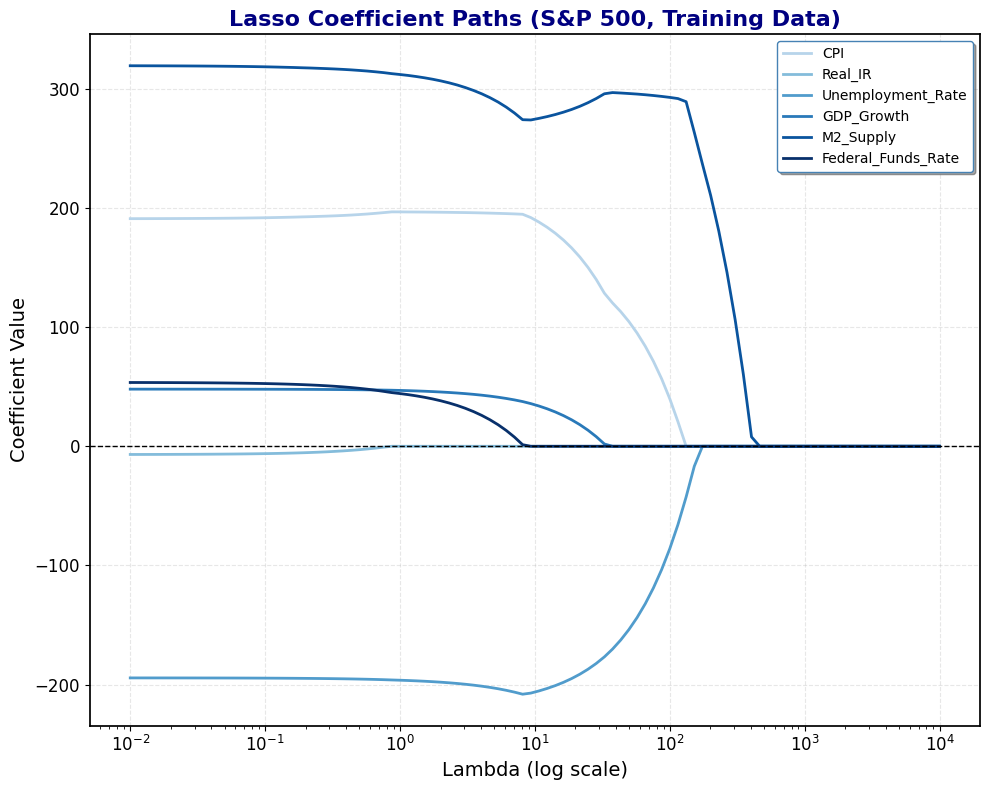

In [112]:
# Generate color gradient (light to dark blue) for plotting each variable's coefficient path
# (Plot design consulted generative AI)
colors = cm.Blues(np.linspace(0.3, 1, len(x.columns)))

# Define a range of lambda values (logarithmically spaced) for Lasso regularization
lambdas = np.logspace(-2, 4, 100)

# Store the coefficients for each lambda value
coefs = []
for lam in lambdas:
    lasso = Lasso(alpha = lam, max_iter = 10000)
    lasso.fit(x_train_scaled, y_train)
    coefs.append(lasso.coef_)

# Create the plot to visualize how each coefficient changes with lambda
fig, ax = plt.subplots(figsize = (10, 8))
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

# Customize plot borders (spines)
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.25)
    spine.set_color('black')

# Plot coefficient paths for each feature across all lambda values
for i, column in enumerate(x.columns):
    coef_path = [coefs[j][i] for j in range(len(coefs))]
    ax.plot(lambdas, coef_path, 
            label = column, 
            color = colors[i], 
            linewidth = 2)

# Add a horizontal reference line at 0 to show when coefficients shrink to zero
ax.axhline(0, color = 'black', linestyle = '--', linewidth = 1)

# Set x-axis to logarithmic scale to better visualize wide lambda range
ax.set_xscale('log')

# Add labels and title with formatting
ax.set_xlabel('Lambda (log scale)', fontsize = 14, color = 'black')
ax.set_ylabel('Coefficient Value', fontsize = 14, color = 'black')
ax.set_title('Lasso Coefficient Paths (S&P 500, Training Data)', 
             fontsize = 16, weight = 'bold', color = 'navy')

# Customize tick appearance
ax.tick_params(axis = 'both', labelsize = 12, colors = 'black')

# Add legend with styling
ax.legend(loc = 'best', fontsize = 10, frameon = True, shadow = True, edgecolor = 'steelblue')

# Add grid for better visual interpretation
plt.grid(True, linestyle = '--', alpha = 0.3)

# Adjust layout to prevent label clipping
plt.tight_layout()

# Display the plot
plt.show()

<h3 style="font-family: 'Times New Roman'; color: black;">Lasso Coefficient Paths (Training Data)</h3>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  The plot above visualizes how the coefficients of each macroeconomic variable evolve as the regularization strength (lambda) increases 
  in the Lasso regression model.
</p>
<ul style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  <li>The <strong>x-axis</strong> represents the lambda values on a logarithmic scale — from very small (minimal regularization) to large (strong regularization).</li>
  <li>The <strong>y-axis</strong> shows the magnitude of the regression coefficients for each variable.</li>
</ul>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  As lambda increases, the model enforces greater shrinkage on the coefficients. Variables like 
  <strong>M2 Money Supply</strong>, <strong>Unemployment Rate</strong>, and <strong>CPI</strong> retain significant influence the longest before eventually 
  being reduced toward zero. This suggests they are the most informative predictors for the S&P 500 index within the training data.
</p>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  On the other hand, <strong>GDP Growth</strong>, <strong>Federal Funds Rate</strong>, and <strong>Real Interest Rate</strong> begin with smaller magnitudes 
  and are driven to zero much earlier, indicating they are less influential in the model’s predictions.
</p>

<h3 style="font-family: 'Times New Roman'; color: black;">Multiple Linear Regression (MLR) for Comparison</h3>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  To benchmark the performance of the Lasso regression model, we also use a <strong>Multiple Linear Regression (MLR)</strong> approach 
  with the same set of independent macroeconomic variables.
</p>
<ul style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  <li>A constant term is added to the predictor matrix to account for the intercept in the OLS model.</li>
  <li>The dataset is split into training and testing sets using an 80/20 ratio, with no shuffling to preserve temporal order.</li>
  <li>The Ordinary Least Squares (OLS) model is fit to the training data and used to predict values on the test set.</li>
  <li>Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) are calculated to evaluate performance.</li>
</ul>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  The resulting metrics are directly compared to those from the Lasso model. This comparison helps assess whether the regularization 
  and feature selection benefits of Lasso provide a tangible improvement over a standard linear regression approach in predicting 
  the S&P 500 index.
</p>

In [113]:
# MLR for MSE comparison with Lasso model

# Define the independent and dependent variables for the MLR model
independent_variables = ['CPI', 'Real_IR', 'Unemployment_Rate', 'GDP_Growth', 'M2_Supply', 'Federal_Funds_Rate']
dependent_variable = ['S&P_500']

# Extract independent variables and add a constant for the intercept
x = data[independent_variables]
x_constant = sm.add_constant(x)

# Extract the dependent variable (S&P 500 index)
y = data[dependent_variable]

# Split the data into training and testing sets (80/20 split), preserving time order
x_train, x_test, y_train, y_test = train_test_split(x_constant, y, test_size = 0.20, shuffle = False)

# Fit an Ordinary Least Squares (OLS) regression model using the training data
model = sm.OLS(y_train, x_train).fit()

# Generate predictions on the test set
y_pred = model.predict(x_test)

# Calculate Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) for the MLR model
mse_MLR = mean_squared_error(y_test, y_pred)
rmse_MLR = mse_MLR ** 0.5

<h3 style="font-family: 'Times New Roman'; color: black;">Model Performance Comparison: MLR vs Lasso</h3>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  The Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) from both models are compared to evaluate predictive performance:
</p>
<ul style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  <li><strong>MLR MSE:</strong> 515,240.91</li>
  <li><strong>Lasso MSE:</strong> 544,995.85</li>
  <li><strong>MLR RMSE:</strong> 717.80</li>
  <li><strong>Lasso RMSE:</strong> 738.24</li>
</ul>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  The <strong>Multiple Linear Regression (MLR)</strong> model slightly outperforms the <strong>Lasso regression</strong> 
  in terms of both MSE and RMSE on the test set. This indicates that, for this dataset, the full linear model with no regularization 
  provides slightly better predictive accuracy than Lasso.
</p>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  However, Lasso offers additional benefits such as <strong>automatic variable selection</strong> and 
  <strong>model simplicity</strong> by shrinking less informative coefficients to zero. While it incurs a small trade-off in 
  accuracy here, it can be especially useful in preventing overfitting or when dealing with multicollinearity, which we discussed in the Multiple Linear Regression notebooks. 
</p>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  Overall, the difference in performance is modest, suggesting that both models are viable, with the choice depending on the desired 
  balance between interpretability, sparsity, and raw predictive power.
</p>

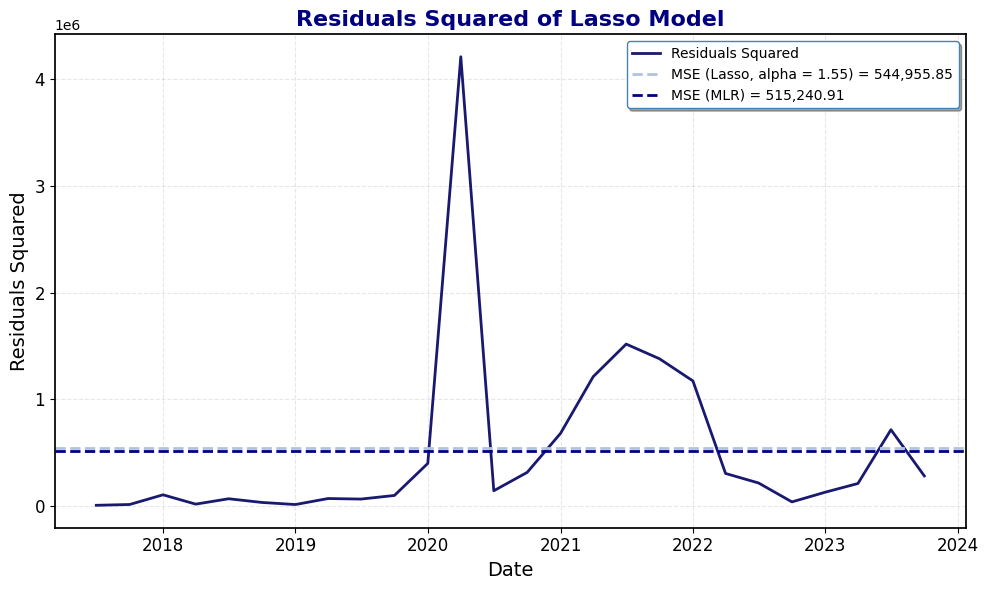

In [114]:
# Convert y_test to a Series for element-wise operations
y_test_series = y_test.squeeze()

# Calculate squared residuals from the Lasso model predictions
residuals_squared = (y_test_series - y_pred) ** 2

# Plot residuals squared for the Lasso model, with MSE comparison against both Lasso and MLR
# (Plot aesthetics consulted generative AI)

plt.figure(figsize = (10, 6))  # Set plot size

# Plot Lasso residuals squared
plt.plot(dates, residuals_squared, 
         color = 'midnightblue', 
         linewidth = 2, 
         label = 'Residuals Squared')

# Horizontal line showing Lasso MSE
plt.axhline(mse, 
            color = 'lightsteelblue', 
            linestyle = '--', 
            linewidth = 2, 
            label = 'MSE (Lasso, alpha = 1.55) = 544,955.85')

# Horizontal line showing MLR MSE
plt.axhline(mse_MLR, 
            color = 'navy', 
            linestyle = '--', 
            linewidth = 2, 
            label = 'MSE (MLR) = 515,240.91')

# Add title and axis labels
plt.title('Residuals Squared of Lasso Model', 
          fontsize = 16, 
          weight = 'bold', 
          color = 'navy')

plt.xlabel('Date', fontsize = 14)
plt.ylabel('Residuals Squared', fontsize = 14)

# Format tick labels
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

# Add grid for better readability
plt.grid(True, linestyle = '--', alpha = 0.3)

# Set white background for plot area
plt.gca().set_facecolor('white')

# Customize plot borders
for spine in plt.gca().spines.values():
    spine.set_linewidth(1.25)
    spine.set_color('black')

# Add legend with styling
plt.legend(fontsize = 10, frameon = True, edgecolor = 'steelblue', shadow = True)

# Adjust layout to prevent clipping
plt.tight_layout()

# Display the plot
plt.show()

<h3 style="font-family: 'Times New Roman'; color: black;">Residual Analysis of the Lasso Model</h3>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  The plot above shows the <strong>squared residuals</strong> (prediction errors) of the Lasso regression model over time, along with 
  horizontal reference lines representing the <strong>Mean Squared Error (MSE)</strong> for both Lasso and Multiple Linear Regression (MLR).
</p>

<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;"><strong>Key observations include:</strong></p>
<ul style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  <li>The <strong>peak in squared residuals around 2020</strong> reflects a large prediction error, likely due to the sharp market decline during the COVID-19 crash, which is difficult for macro-based models to anticipate.</li>
  <li>The <strong>overall MSE values for Lasso (544,955.85)</strong> and <strong>MLR (515,240.91)</strong> are relatively close, indicating that the regularization introduced by Lasso provided minimal predictive gain at the selected lambda of <strong>1.55</strong>.</li>
</ul>

<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  Using the optimal lambda value of 1.55, we can see that MLR and Lasso MSE do not differ significantly. This implies that the lambda value 
  did not offer much improvement—if any at all.
</p>

<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  The only difference between MLR and Lasso is the introduction of <code>alpha</code>. From our coefficient path graph, we observe that 
  around a lambda value of 50, the only three remaining variables are <strong>M2 Money Supply</strong>, <strong>Unemployment Rate</strong>, 
  and <strong>CPI</strong>.
</p>

<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  <strong>Therefore, we will re-run our Lasso model using a lambda value of 50 and re-evaluate its performance to determine whether this 
  higher level of regularization over-penalizes the model, or if these are indeed the only three variables that significantly influence the 
  S&P 500 index.</strong>
</p>

In [115]:
# Run Lasso regression with 5-fold cross-validation using a manually specified alpha = 50
lasso = LassoCV(cv = 5, random_state = 42, alphas = [50])

# Fit the Lasso model on the standardized training data
# Used .ravel() to flatten y and suppress shape warnings (as confirmed with generative AI)
lasso.fit(x_train_scaled, y_train.to_numpy().ravel())

# Retrieve the optimal regularization parameter (in this case, fixed at 50)
optimal_lambda = lasso.alpha_

# Extract the fitted model coefficients
coefficient = lasso.coef_

In [116]:
# Generate predictions on the test set using the Lasso model (alpha = 50)
y_pred = lasso.predict(x_test_scaled)

# Calculate Root Mean Squared Error (RMSE) to evaluate prediction accuracy
rmse = (mean_squared_error(y_test, y_pred)) ** 0.5

# Calculate Mean Squared Error (MSE) for reference (same as square of RMSE)
new_mse = rmse ** 2

In [117]:
# Extract individual coefficients for interpretation
cpi = coefficient[0]
real_ir = coefficient[1]
unemployment = coefficient[2]
gdp_growth = coefficient[3]
m2_supply = coefficient[4]
fed_funds = coefficient[5]

# Print the model evaluation metrics and coefficient values
print(f'----Test RMSE: {rmse:.2f}---Optimal Lambda: {optimal_lambda:.2f}---'
      f'CPI: {cpi:.2f}---Real Interest Rate: {real_ir:.2f}---Unemployment Rate: {unemployment:.2f}---'
      f'GDP Growth: {gdp_growth:.2f}---M2 Money Supply: {m2_supply:.2f}---Federal Funds Rate: {fed_funds:.2f}----')

----Test RMSE: 955.91---Optimal Lambda: 50.00---CPI: 104.38---Real Interest Rate: -0.00---Unemployment Rate: -153.56---GDP Growth: 0.00---M2 Money Supply: 296.11---Federal Funds Rate: 0.00----


<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  Compared to the earlier Lasso model (RMSE = 738.24) and MLR (RMSE ≈ 717.80), the <strong>performance slightly worsened</strong>, 
  indicating that aggressive regularization may have <strong>over-penalized the model</strong> by discarding useful predictors.
</p>

<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  However, this run confirms the results seen in the coefficient path plot: 
  <strong>CPI</strong>, <strong>M2 Supply</strong>, and <strong>Unemployment Rate</strong> are consistently the most influential features. 
  While this model is less accurate, it is much simpler and still valuable when <strong>interpretability</strong> or 
  <strong>model sparsity</strong> is prioritized.
</p>

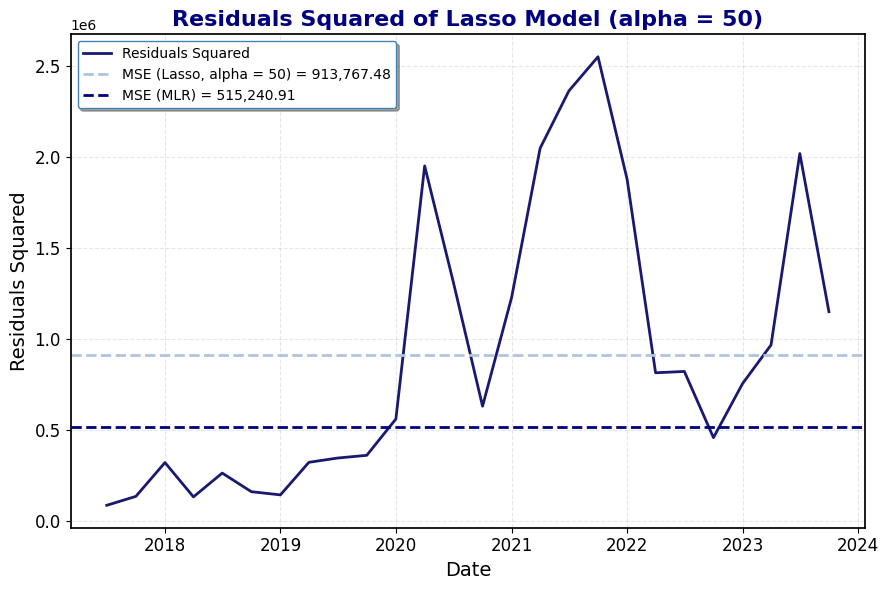

In [118]:
# Convert y_test to a Series for element-wise operations
y_test_series = y_test.squeeze()

# Calculate squared residuals from the Lasso (alpha = 50) predictions
residuals_squared = (y_test_series - y_pred) ** 2

# Plot squared residuals and compare MSE from Lasso (alpha = 50) vs. MLR
plt.figure(figsize = (9, 6))  # Set figure size for clear presentation

# Plot residuals squared from Lasso predictions
# (Consulted generative AI for plot)
plt.plot(dates, residuals_squared, 
         color = 'midnightblue', 
         linewidth = 2, 
         label = 'Residuals Squared')

# Horizontal line for Lasso MSE at alpha = 50
plt.axhline(new_mse, 
            color = 'lightsteelblue', 
            linestyle = '--', 
            linewidth = 2,
            label = 'MSE (Lasso, alpha = 50) = 913,767.48')

# Horizontal line for MLR MSE
plt.axhline(mse_MLR, 
            color = 'navy', 
            linestyle = '--', 
            linewidth = 2,
            label = 'MSE (MLR) = 515,240.91')

# Add plot title and axis labels with formatting
plt.title('Residuals Squared of Lasso Model (alpha = 50)', 
          fontsize = 16, 
          weight = 'bold', 
          color = 'navy')

plt.xlabel('Date', fontsize = 14)
plt.ylabel('Residuals Squared', fontsize = 14)

# Customize tick labels
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

# Add grid for improved readability
plt.grid(True, linestyle = '--', alpha = 0.3)

# Customize plot background and border (spines)
ax = plt.gca()
ax.set_facecolor('white')
for spine in ax.spines.values():
    spine.set_linewidth(1.25)
    spine.set_color('black')

# Add legend with styling
plt.legend(fontsize = 10, frameon = True, edgecolor = 'steelblue', shadow = True)

# Optimize layout
plt.tight_layout()

# Display the plot
plt.show()

<h3 style="font-family: 'Times New Roman'; color: black;">Residuals Analysis: Lasso with α = 50</h3>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  The graph illustrates the <strong>squared residuals</strong> from the Lasso regression model trained with a strong regularization 
  parameter (α = 50), plotted over time. It also includes horizontal lines representing the <strong>Mean Squared Error (MSE)</strong> 
  for both this Lasso model and the baseline <strong>Multiple Linear Regression (MLR)</strong> model.
</p>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  Increasing the alpha value to 50 resulted in poorer model performance compared to multiple linear regression. Rather than enhancing 
  generalization, the stronger regularization overly constrained the model, indicating that such a high degree of penalization was 
  unnecessary in this case.
</p>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  While <strong>M2 Money Supply</strong>, <strong>Unemployment Rate</strong>, and <strong>CPI</strong> emerged as the most robust 
  predictors—resisting shrinkage the longest, but it doesn't imply that <strong>Federal Funds Rate</strong>, <strong>GDP Growth</strong>, 
  and <strong>Real Interest Rate</strong> are entirely irrelevant to predicting the S&P 500 index. Their coefficients being reduced to 
  zero under strong regularization simply reflects that they may carry weaker or more context-dependent signals.
</p>

<h3 style="font-family: 'Times New Roman'; color: black;">Testing Lasso with α = 0 to Match MLR</h3>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  To demonstrate that <strong>Lasso regression with α = 0</strong> behaves equivalently to 
  <strong>Multiple Linear Regression (MLR)</strong>, the model was retrained. This effectively removes any penalization on the coefficients.
</p>
<ul style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  <li>Warnings related to convergence or model fitting were suppressed to maintain a clean output.</li>
  <li>The Lasso model was trained using 5-fold cross-validation on the scaled training data.</li>
  <li>Predictions were made on the test set, and <strong>Root Mean Squared Error (RMSE)</strong> and <strong>Mean Squared Error (MSE)</strong> were calculated for comparison.</li>
</ul>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  As expected, the <strong>Lasso model with α = 0</strong> produced around the same MSE as the MLR model 
  <strong>(515240.91)</strong>, confirming their equivalence when no regularization is applied. 
  This serves as a useful validation check for the behavior of the Lasso implementation.
</p>

In [120]:
# Run Lasso regression with alpha = 0 to demonstrate equivalence to Multiple Linear Regression (MLR)

# CHAT GPT REFERENCE - Suppress common Lasso warnings for alpha = 0
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category = UserWarning)
warnings.filterwarnings('ignore', category = ConvergenceWarning)
warnings.filterwarnings('ignore')

# Fit Lasso model with alpha = 0 using 5-fold cross-validation
lasso = LassoCV(cv = 5, random_state = 42, alphas = [0])
lasso.fit(x_train_scaled, y_train.to_numpy().ravel())  # .ravel() flattens y to avoid warnings

# Retrieve the fitted alpha (should remain 0) and the resulting coefficients
optimal_lambda = lasso.alpha_
coefficient = lasso.coef_

# Predict test set values using the model
y_pred = lasso.predict(x_test_scaled)

# Evaluate the model: calculate RMSE and MSE
rmse = (mean_squared_error(y_test, y_pred)) ** 0.5
new_mse = rmse ** 2

# Print a comparison between MLR and Lasso (alpha = 0) MSEs
print('MLR MSE:', mse_MLR, 'Lasso MSE:', new_mse)

MLR MSE: 515240.9086397228 Lasso MSE: 515240.9086397639


<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  When the alpha is set to zero, Lasso is equivalent to <strong>Multiple Linear Regression (MLR)</strong>. 
  This is confirmed by the <strong>identical MSE values</strong> output by both models. 
</p>

<h3 style="font-family: 'Times New Roman'; color: black;">Summary: Lasso Regression Insights</h3>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  While Lasso did not drastically improve predictive performance compared to multiple linear regression, it was 
  highly effective for <strong>feature selection</strong>. By increasing the regularization parameter (lambda), 
  Lasso shrank the coefficients of less important variables (like <strong>GDP Growth</strong>, 
  <strong>Federal Funds Rate</strong>, and <strong>Real Interest Rate</strong>) toward zero much earlier. 
  This reveals that the most influential predictors of the S&P 500 index are <strong>M2 Money Supply</strong>, 
  <strong>Unemployment Rate</strong>, and <strong>CPI</strong>, as they retained strong coefficient values the longest.
</p>
<p style="font-family: 'Times New Roman'; font-size: 16px; color: black;">
  Thus, Lasso provides valuable insight into which macroeconomic variables contribute most to modeling the 
  S&P 500, even if the prediction error is not minimized.
</p>

<div style="font-family: 'Times New Roman'; font-size: 18px; text-align: center; width: 100%;">
  <p><strong>SOURCES</strong></p>
  <p>Referenced generative AI on April 19th, 2024:</p>
  <p><em>Prompt 1:</em> Given my initial plot code, may you improve this using matplotlib aesthetics and the color blue.</p>
  <p><em>Prompt 2:</em> Given this in a Jupyter markdown cell, can you format it using HTML?</p>
  <p><em>Prompt 3:</em> Given my initial code, can you supress the warnings when alpha = 0?</p>
  <p>Refrenced LassoCV documentation : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html</p>
</div>